### Salary prediction, episode II: make it actually work (4 points)

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__. Try __at least 3 options__ from the list below for a passing grade. Write a short report about what you have tried. More ideas = more bonus points.

__Please be serious:__ " plot learning curves in MAE/epoch, compare models based on optimal performance, test one change at a time. You know the drill :)

You can use either __pytorch__ or __tensorflow__ or any other framework (e.g. pure __keras__). Feel free to adapt the seminar code for your needs. For tensorflow version, consider `seminar_tf2.ipynb` as a starting point.


### Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

from pathlib import Path
sources_path = Path("/content/drive/MyDrive/hse")

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing as tp
from collections import Counter
import copy
from tqdm import trange
from IPython.display import clear_output
from IPython.display import display

import nltk

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

from tqdm.auto import tqdm

%matplotlib inline

### Data Preparation

In [20]:
data = pd.read_csv(f"{sources_path}/Train_rev1.zip", compression='zip', index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

In [21]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

def tokenize(string: str) -> str:
    string = str(string)
    if string:
        return ' '.join(tokenizer.tokenize(str(string))).lower()
    return ''

In [22]:
data['Title'] = data['Title'].apply(tokenize)
data['FullDescription'] = data['FullDescription'].apply(tokenize)

In [23]:
# Count how many times does each token occur in both "Title" and "FullDescription" in total
def count_tokens(column: str) -> tp.Counter:
    token_counts = Counter()
    for row in data[column]:
        token_counts.update(row.split())
    return token_counts

token_counts = count_tokens('Title') + count_tokens('FullDescription')

In [24]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [25]:

token_to_id = dict(zip(tokens, range(len(tokens))))

UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [26]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

In [27]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [28]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

Using cuda device


In [29]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Training utils

In [68]:
BATCH_SIZE = 128
EPOCHS = 10
interval = 100

In [47]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('mse')
    ax1.plot(train_ts, train_mse, c='darkblue', lw=3)
    ax1.set_ylim([0., np.quantile(train_mse, 0.75)])
    ax2.set_title('val mae')
    ax2.set_xlabel('time (epochs)')
    ax2.set_ylim([0.0, 1.0])
    ax2.plot(val_ts, val_mae, c='green', marker='o', lw=5)
    ax1.grid()
    ax2.grid()
    plt.show()

In [48]:
def train(epoch, data, model, loss_fn, optimizer, word_dropout=0.0):
        model.train()
        num_batches = len(data_train) // BATCH_SIZE
        for i, batch in enumerate(iterate_minibatches(data_train, batch_size=BATCH_SIZE,
                                                      device=device, word_dropout=word_dropout)):
            pred = model(batch)
            loss = loss_fn(pred, batch[TARGET_COLUMN])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % interval == 0:
                t = epoch + (i + 1) / num_batches
                train_ts.append(t)
                train_mse.append(loss.item())
                show_progress(t)

In [49]:
def test(epoch, data, model, loss_fn):
    model.eval()

    num_batches = len(data_train) // BATCH_SIZE
    size = len(data_train)
    squared_error, abs_error = 0, 0
    num_samples = 0

    with torch.no_grad():

        for batch in iterate_minibatches(data, batch_size=BATCH_SIZE, shuffle=False, device=device):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)

    val_ts.append(epoch + 1)
    mae, mse = abs_error.detach().cpu().numpy() / num_samples, squared_error.detach().cpu().numpy() / num_samples
    val_mae.append(mae)
    val_mse.append(mse)

    show_progress(epoch + 1)

    return model, mse, mae

In [67]:
def run_experiment(model, criterion, optimizer, word_dropout=0.0):

  best_mae = float('inf')
  best_model_weights = copy.deepcopy(model.state_dict())

  for t in trange(EPOCHS):
      train(t, data_train, model, criterion, optimizer, word_dropout=word_dropout)
      model, mse, mae = test(t, data_val, model, criterion)

      if mae < best_mae:
          best_mae = mae
          best_model_weights = copy.deepcopy(model.state_dict())

  return best_model_weights, best_mae

### CNN

In [ ]:
class CategorialEncoder(nn.Module):
    def __init__(self, in_dim=len(categorical_vectorizer.vocabulary_), hid_size=64, batch_norm=False, dropout=0.0):
        super().__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(in_dim, 1024)
        self.fc2 = nn.Linear(1024, hid_size)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        fc1 = self.dropout(F.relu(self.bn(self.fc1(x)))) if self.batch_norm else self.dropout(F.relu(self.fc1(x)))
        return self.fc2(fc1)


class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64, batch_norm=False, dropout=0.0, pool='max'):
        super().__init__()
        self.batch_norm = batch_norm
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=32)
        self.conv = nn.Conv1d(32, hid_size, kernel_size=3)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=dropout)

        if pool == "max":
            self.pool  = self.max_pool
        elif pool == "avg":
            self.pool = self.avg_pool
        elif pool == "softmax":
            self.pool = self.softmax_pool

    def max_pool(self, x):
        return x.max(dim=-1).values

    def avg_pool(self, x):
        return x.mean(dim=-1)

    def softmax_pool(self, x):
        return (x * torch.nn.Softmax(dim=-1)(x)).sum(-1)

    def forward(self, x, pool='max'):
        emb = self.dropout(self.emb(x).transpose(2, 1))
        conv = F.relu(self.bn(self.conv(emb))) if self.batch_norm else F.relu(self.conv(emb))
        return self.pool(conv)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, dropout=0., batch_norm=False, pool='max'):
        super().__init__()
        self.title_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool)
        self.descr_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool)
        self.categ_encoder = CategorialEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm)
        self.descr_encoder.emb = self.title_encoder.emb
        self.out = nn.Sequential(nn.Linear(hid_size * 3, hid_size),
                                  nn.BatchNorm1d(hid_size),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(hid_size, 1)
                                  )

    def forward(self, batch):
        x1 = self.title_encoder(batch['Title'])
        x2 = self.descr_encoder(batch['FullDescription'])
        x3 = self.categ_encoder(batch['Categorical'])
        x = torch.cat((x1, x2, x3), axis=-1)
        return torch.squeeze(self.out(x))

### Эксперименты

#### Эксперимент 1: простая сверточная без "улучшений"

In [ ]:
EPOCHS=10

In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4)

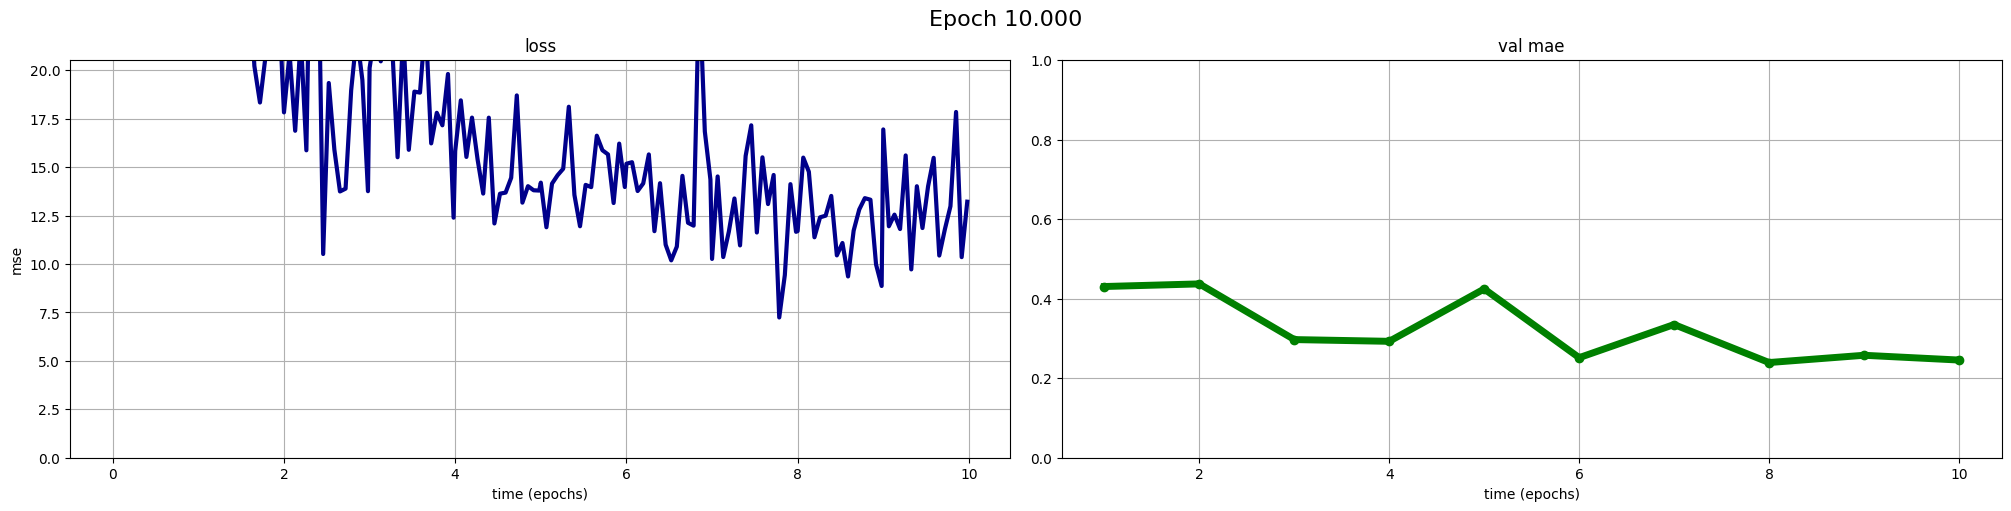

100%|██████████| 10/10 [15:04<00:00, 90.40s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.288079,0.285668,0.147585,0.143478,0.260173,0.109022,0.174596,0.099349,0.112920,0.104091
mae,0.430471,0.437067,0.297042,0.292662,0.424366,0.251564,0.334908,0.239329,0.257596,0.245590





Best MAE = 0.2393


#### Эксперимент 2: вместо SGD - Adam

In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

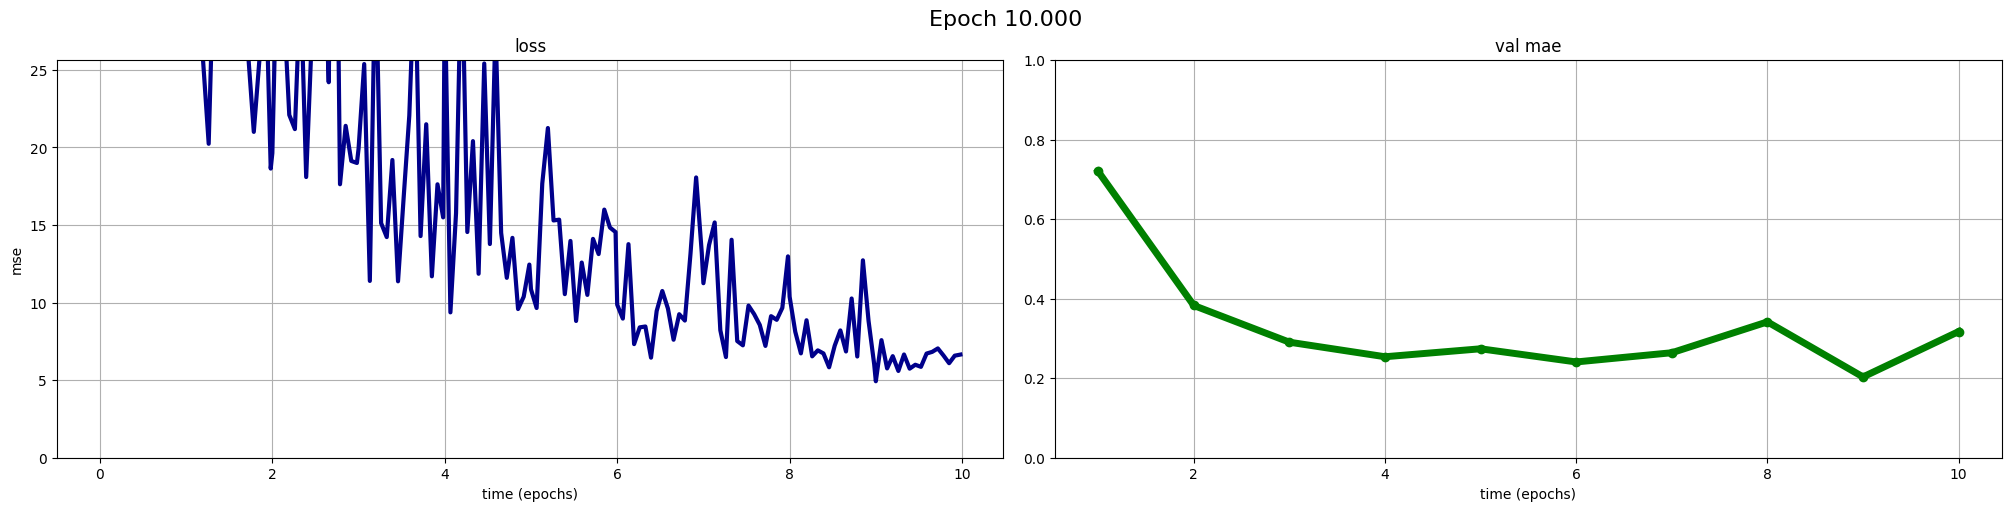

100%|██████████| 10/10 [13:55<00:00, 83.55s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.760822,0.221962,0.141035,0.110150,0.124399,0.098569,0.111934,0.168755,0.073258,0.146071
mae,0.719848,0.382777,0.290497,0.253883,0.273904,0.240790,0.263982,0.341575,0.203134,0.317231




Best MAE = 0.2031


Вывод: работает чуть лучше, чем SGD, будем дальше использовать Adam

#### Эксперимент 3: добавление nn.Dropout

In [ ]:
model = SalaryPredictor(dropout=0.5).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

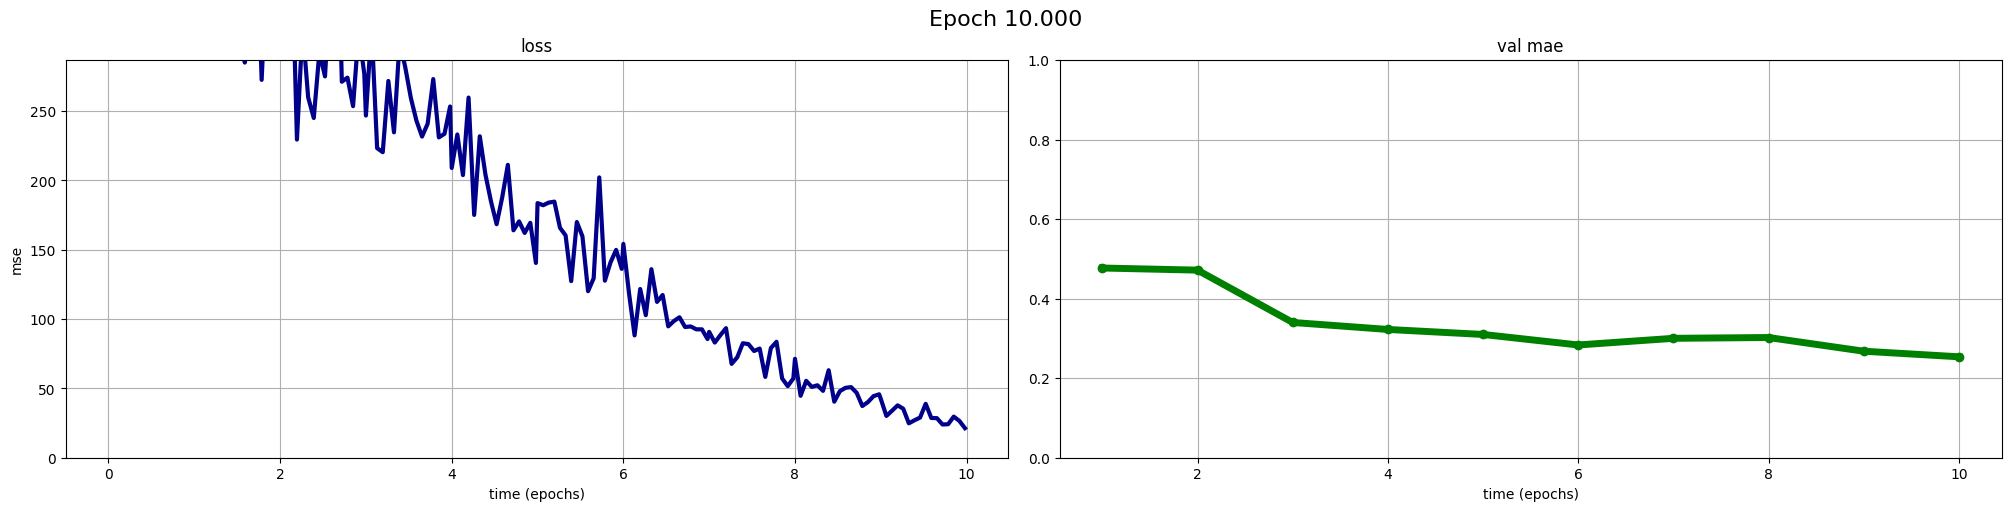

100%|██████████| 10/10 [13:46<00:00, 82.61s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.365625,0.353614,0.189362,0.171429,0.155694,0.133977,0.147515,0.148724,0.118208,0.107943
mae,0.476973,0.471683,0.340098,0.322516,0.309939,0.283502,0.300208,0.302245,0.267814,0.253772




Best MAE = 0.2538


Вывод: скорее всего нужно подольше поучить модель, непонятно лучше ли стало

#### Эксперимент 4: Добавление dropout исходных данных

In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

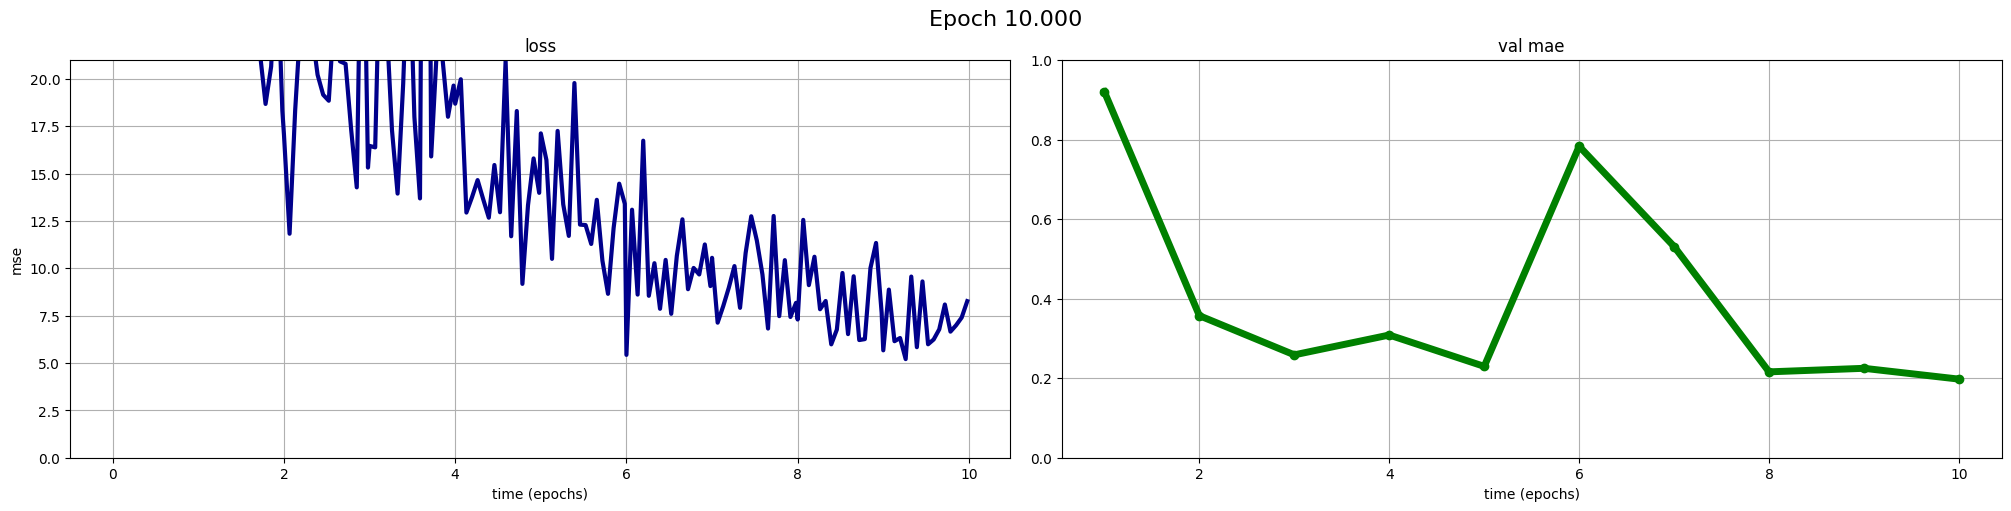

100%|██████████| 10/10 [15:39<00:00, 93.98s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer, word_dropout=0.2)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,1.087820,0.203146,0.114420,0.154105,0.091109,0.692610,0.348253,0.080520,0.085688,0.070491
mae,0.919694,0.357154,0.258647,0.308535,0.229663,0.783022,0.531023,0.215906,0.224812,0.197630




Best MAE = 0.1976


Вывод: с масками в исходном тексте стало лучше!

#### Эксперимент 5: Добавление batch_normalization

In [ ]:
model = SalaryPredictor(batch_norm=True).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

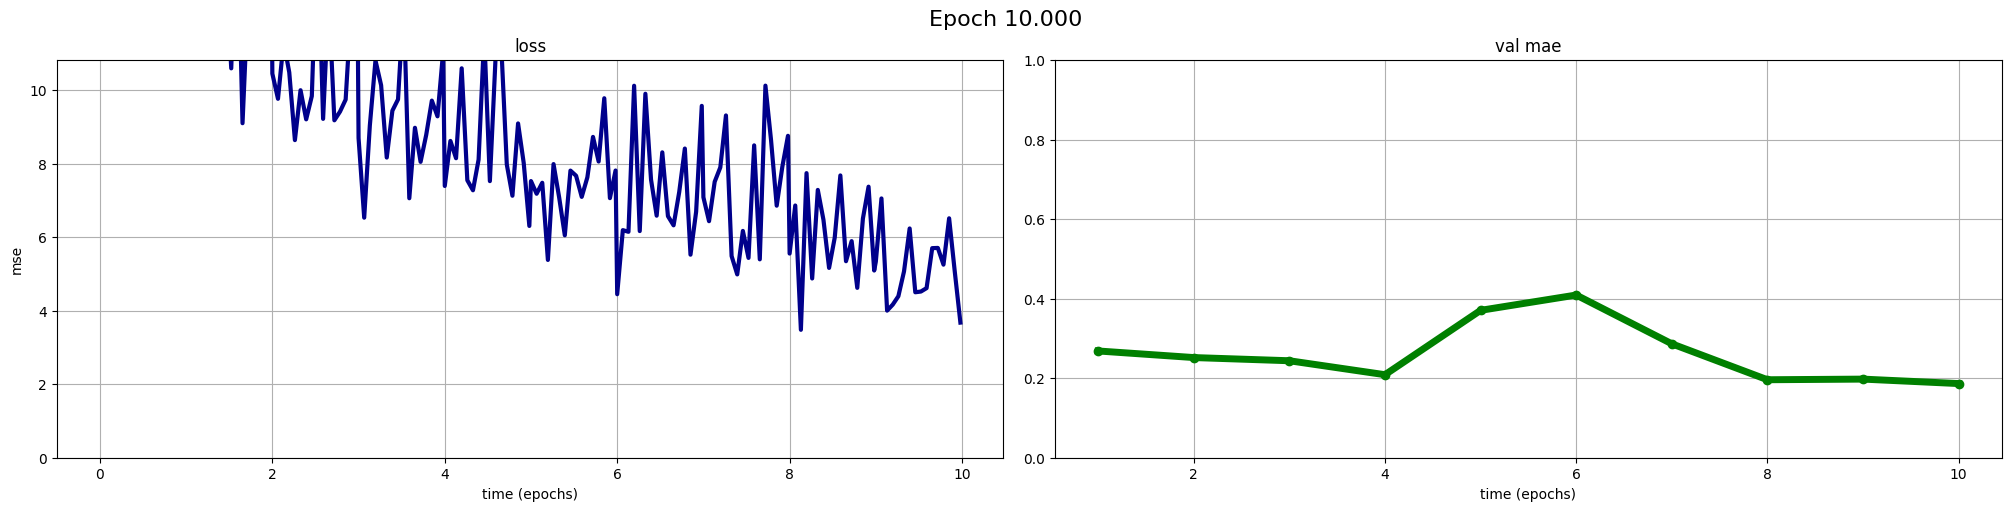

100%|██████████| 10/10 [15:02<00:00, 90.23s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.123729,0.107026,0.098577,0.076522,0.188909,0.218825,0.130822,0.067683,0.067988,0.062247
mae,0.268407,0.251831,0.243821,0.208721,0.370568,0.409062,0.286414,0.196070,0.197652,0.186438




Best MAE = 0.1976


Вывод: batch norm помогает быстрее учиться

#### Эксперимент 6: параллельные свертки

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64, batch_norm=False, dropout=0.0, pool='max'):
        super().__init__()
        self.batch_norm = batch_norm
        self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=32)
        self.conv1 = nn.Conv1d(32, hid_size, kernel_size=3)
        self.conv2 = nn.Conv1d(32, hid_size, kernel_size=3)
        if self.batch_norm:
            self.bn1 = nn.BatchNorm1d(hid_size)
            self.bn2 = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=dropout)

        if pool == "max":
            self.pool  = self.max_pool
        elif pool == "avg":
            self.pool = self.avg_pool
        elif pool == "softmax":
            self.pool = self.softmax_pool

    def max_pool(self, x):
        return x.max(dim=-1).values

    def avg_pool(self, x):
        return x.mean(dim=-1)

    def softmax_pool(self, x):
        return (x * torch.nn.Softmax(dim=-1)(x)).sum(-1)

    def forward(self, x, pool='max'):
        emb = self.dropout(self.emb(x).transpose(2, 1))
        conv1 = F.relu(self.bn1(self.conv1(emb))) if self.batch_norm else F.relu(self.conv1(emb))
        conv2 = F.relu(self.bn2(self.conv2(emb))) if self.batch_norm else F.relu(self.conv2(emb))
        x = torch.cat([conv1, conv2], -1)
        return self.pool(x)

In [ ]:
model = SalaryPredictor(batch_norm=True).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

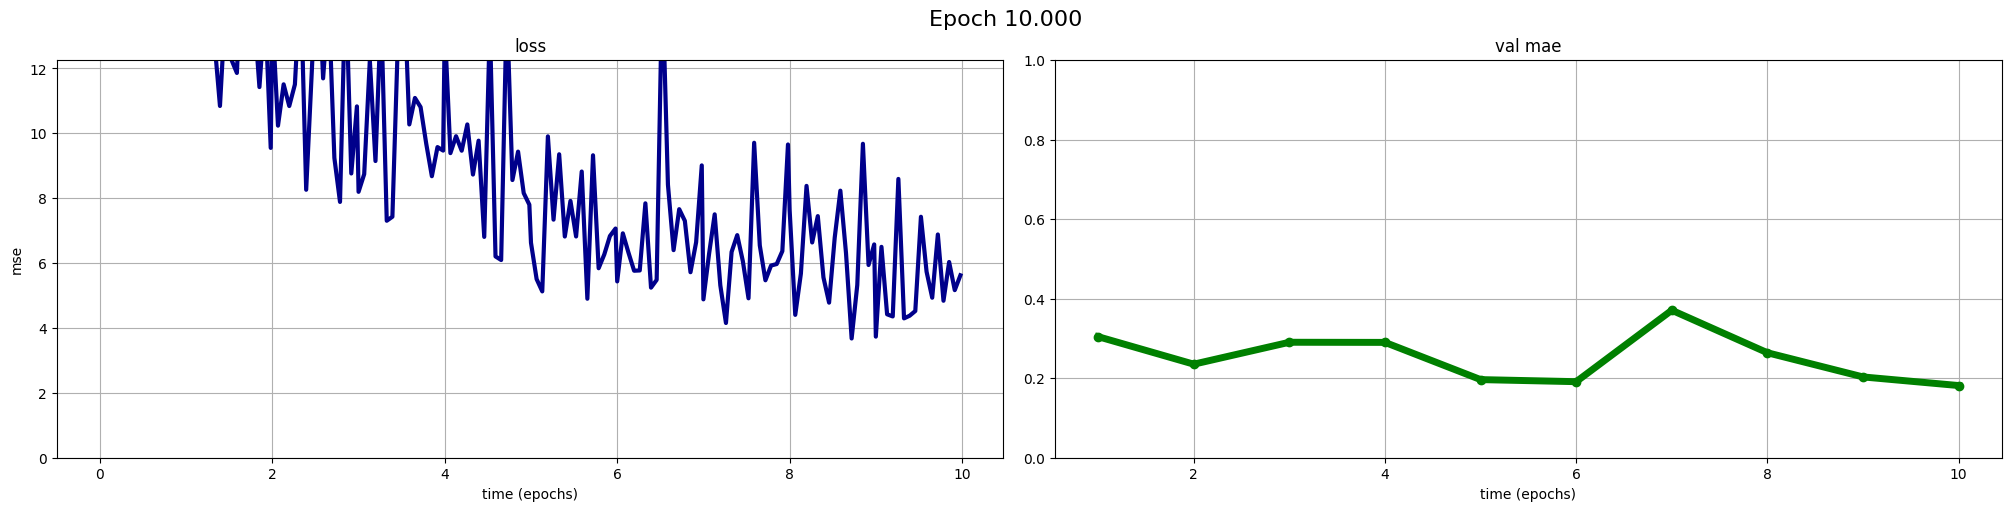

100%|██████████| 10/10 [18:41<00:00, 112.12s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.150276,0.095155,0.133857,0.129975,0.068854,0.065226,0.192477,0.109271,0.071312,0.059810
mae,0.304323,0.235193,0.290308,0.289979,0.196411,0.191206,0.370825,0.263920,0.203109,0.181483




Best MAE = 0.1815


#### Эксперимент 7: разные пулинги

In [ ]:
model = SalaryPredictor(batch_norm=True, pool='avg').to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

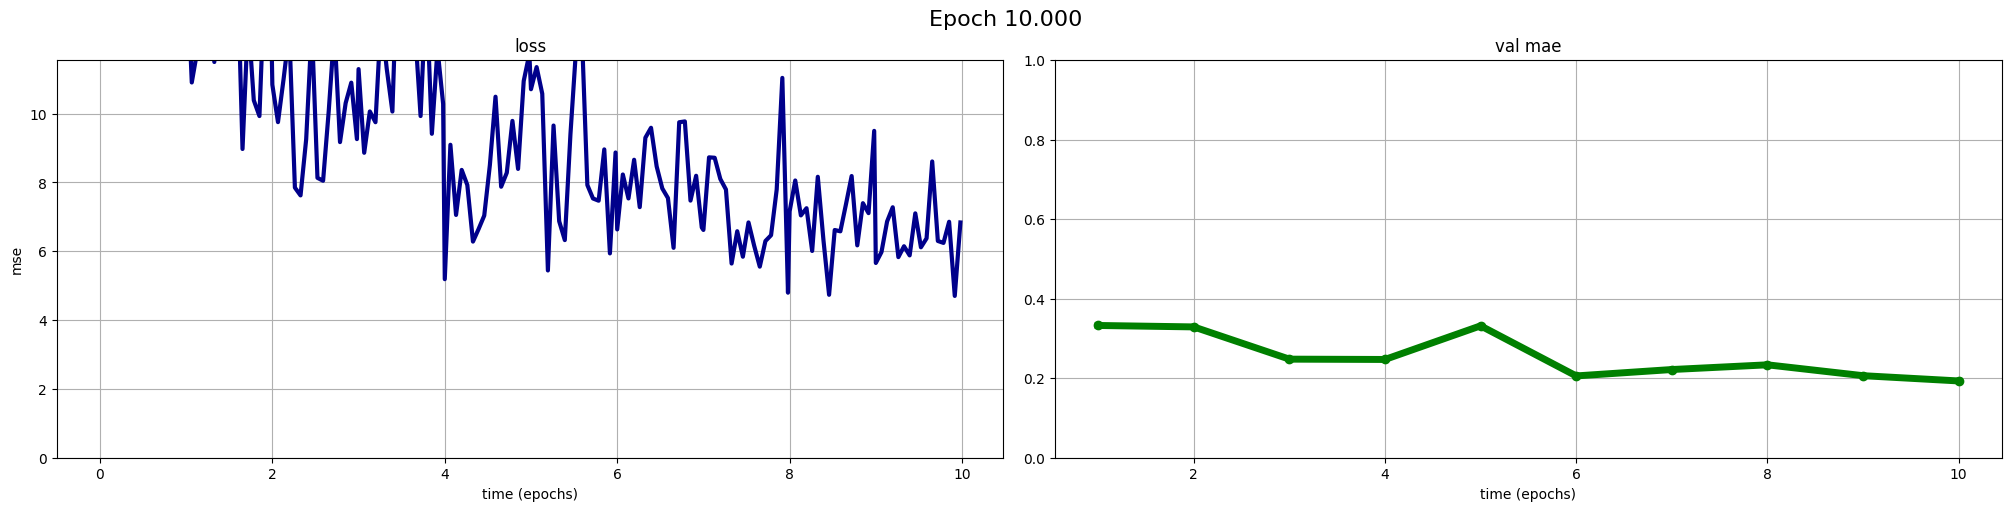

100%|██████████| 10/10 [15:28<00:00, 92.89s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.181230,0.172657,0.106041,0.101232,0.170474,0.074117,0.083754,0.090294,0.074051,0.067102
mae,0.332524,0.328913,0.247840,0.247053,0.331648,0.205674,0.221735,0.233586,0.206279,0.193049




Best MAE = 0.1930


In [ ]:
model = SalaryPredictor(batch_norm=True, pool='softmax').to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

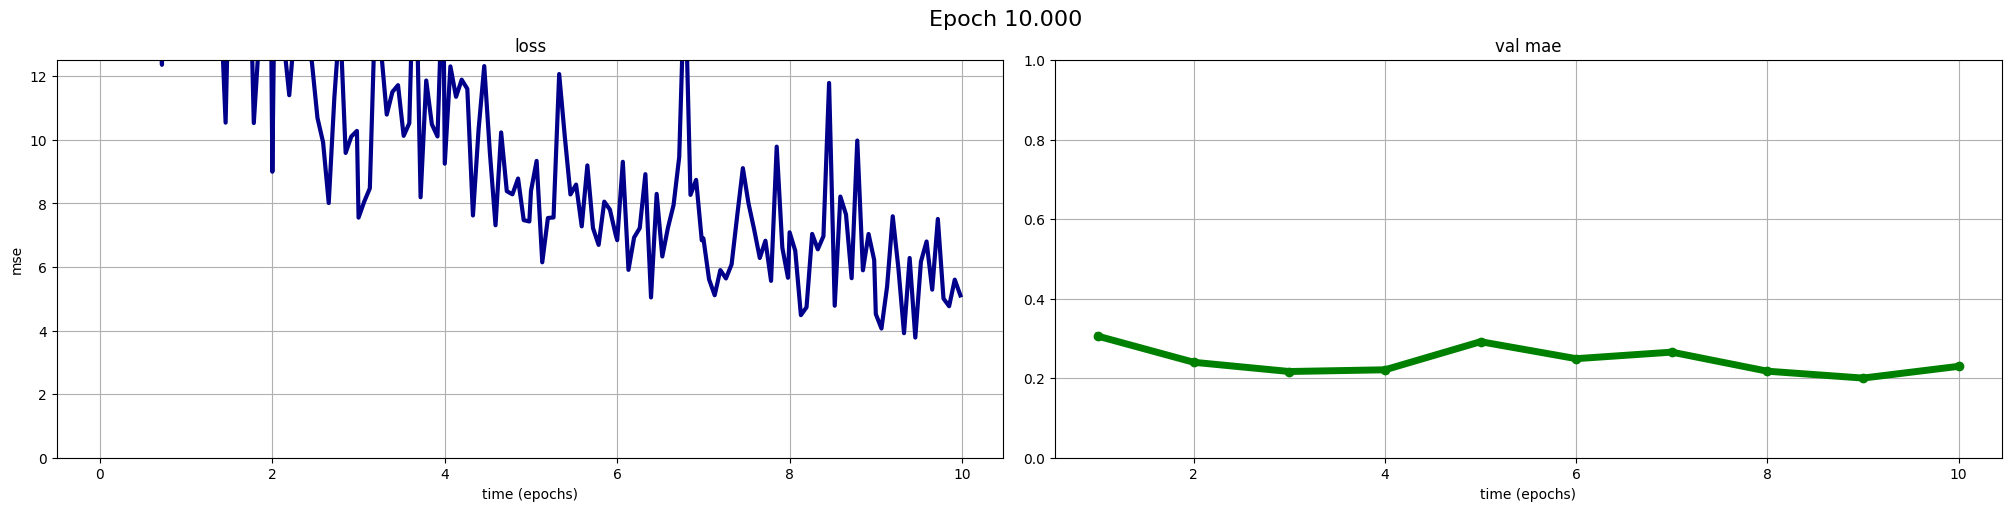

100%|██████████| 10/10 [17:36<00:00, 105.65s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.152484,0.098450,0.082669,0.084980,0.130692,0.101048,0.112444,0.081464,0.070486,0.086082
mae,0.305461,0.239949,0.216775,0.221074,0.291723,0.249069,0.265484,0.217527,0.200283,0.229793




Best MAE = 0.2003


Вывод: в целом, большой разницы между пулингами нет, продолжаем использовать max

#### Эксперимент 8: увеличиваем сетку

In [ ]:
model = SalaryPredictor(batch_norm=True, hid_size=256).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

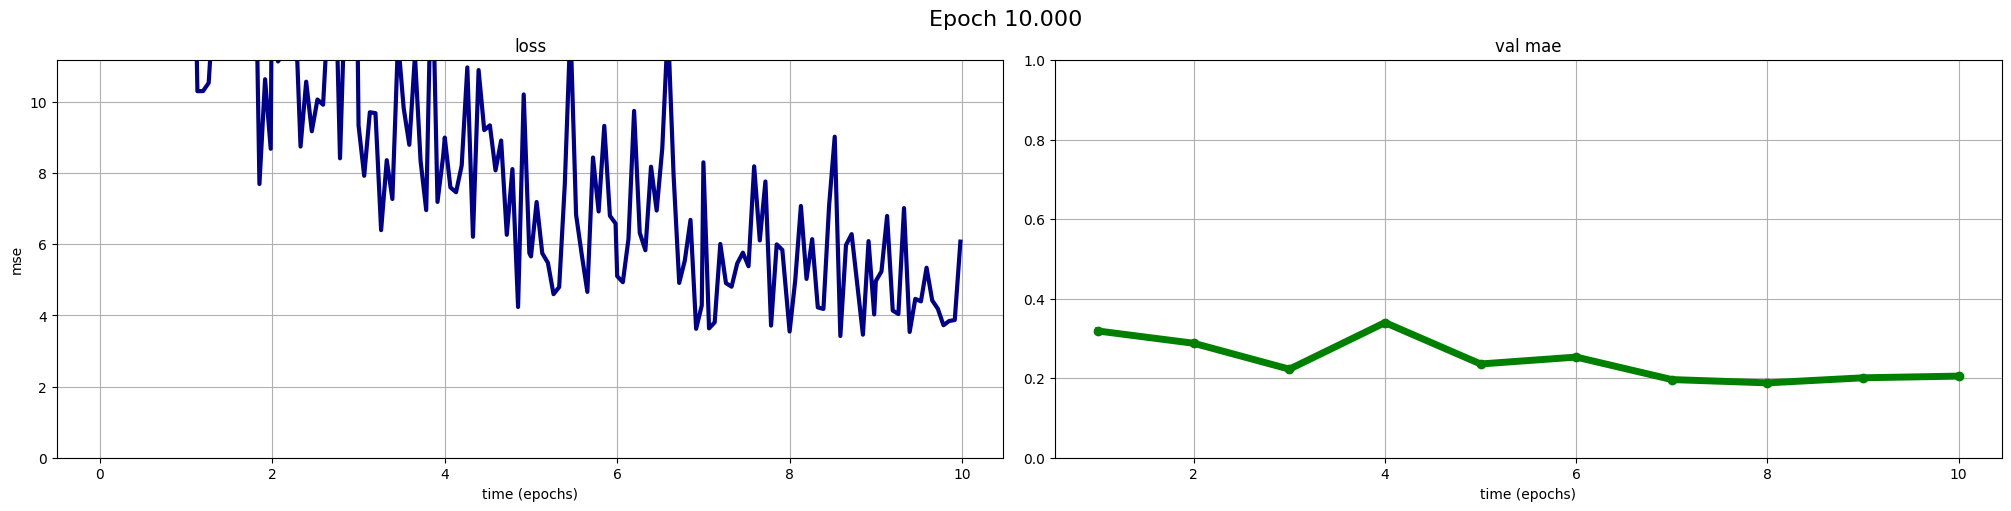

100%|██████████| 10/10 [22:13<00:00, 133.31s/it]


In [ ]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [ ]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.162718,0.131613,0.085306,0.173662,0.091007,0.103585,0.068098,0.063228,0.071469,0.073731
mae,0.318552,0.287752,0.222627,0.339829,0.235720,0.253036,0.196494,0.188226,0.200967,0.205204




Best MAE = 0.1882


Лучше не стало, видимо надо менять архитектуру/делать еще больше нейронов

#### Эксперимент 9: используем предобученные эмбеддинги

In [17]:
import gensim.downloader as api
emb = api.load('glove-twitter-50')

[==================================================] 100.0% 199.5/199.5MB downloaded


In [62]:
embedding_matrix = np.zeros((len(tokens), 50))
for token, i in token_to_id.items():
    embedding_vector = emb.get_vector(token) if token in emb else None
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
embedding_matrix = torch.from_numpy(embedding_matrix).float()

In [73]:
class CategorialEncoder(nn.Module):
    def __init__(self, in_dim=len(categorical_vectorizer.vocabulary_), hid_size=64, batch_norm=False, dropout=0.0):
        super().__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(in_dim, 1024)
        self.fc2 = nn.Linear(1024, hid_size)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        fc1 = self.dropout(F.relu(self.bn(self.fc1(x)))) if self.batch_norm else self.dropout(F.relu(self.fc1(x)))
        return self.fc2(fc1)


class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64, batch_norm=False, dropout=0.0, pool='max', fine_tune=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=not fine_tune)
        self.conv = nn.Conv1d(50, hid_size, kernel_size=3)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=dropout)

        if pool == "max":
            self.pool  = self.max_pool
        elif pool == "avg":
            self.pool = self.avg_pool
        elif pool == "softmax":
            self.pool = self.softmax_pool

    def max_pool(self, x):
        return x.max(dim=-1).values

    def avg_pool(self, x):
        return x.mean(dim=-1)

    def softmax_pool(self, x):
        return (x * torch.nn.Softmax(dim=-1)(x)).sum(-1)

    def forward(self, x, pool='max'):
        emb = self.dropout(self.emb(x).transpose(2, 1))
        conv = F.relu(self.bn(self.conv(emb))) if self.batch_norm else F.relu(self.conv(emb))
        return self.pool(conv)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, dropout=0., batch_norm=False, pool='max', fine_tune=False):
        super().__init__()
        self.title_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool, fine_tune=fine_tune)
        self.descr_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool, fine_tune=fine_tune)
        self.categ_encoder = CategorialEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm)
        self.descr_encoder.emb = self.title_encoder.emb
        self.out = nn.Sequential(nn.Linear(hid_size * 3, hid_size),
                                  nn.BatchNorm1d(hid_size),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(hid_size, 1)
                                  )

    def forward(self, batch):
        x1 = self.title_encoder(batch['Title'])
        x2 = self.descr_encoder(batch['FullDescription'])
        x3 = self.categ_encoder(batch['Categorical'])
        x = torch.cat((x1, x2, x3), axis=-1)
        return torch.squeeze(self.out(x))

In [69]:
model = SalaryPredictor(batch_norm=True).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

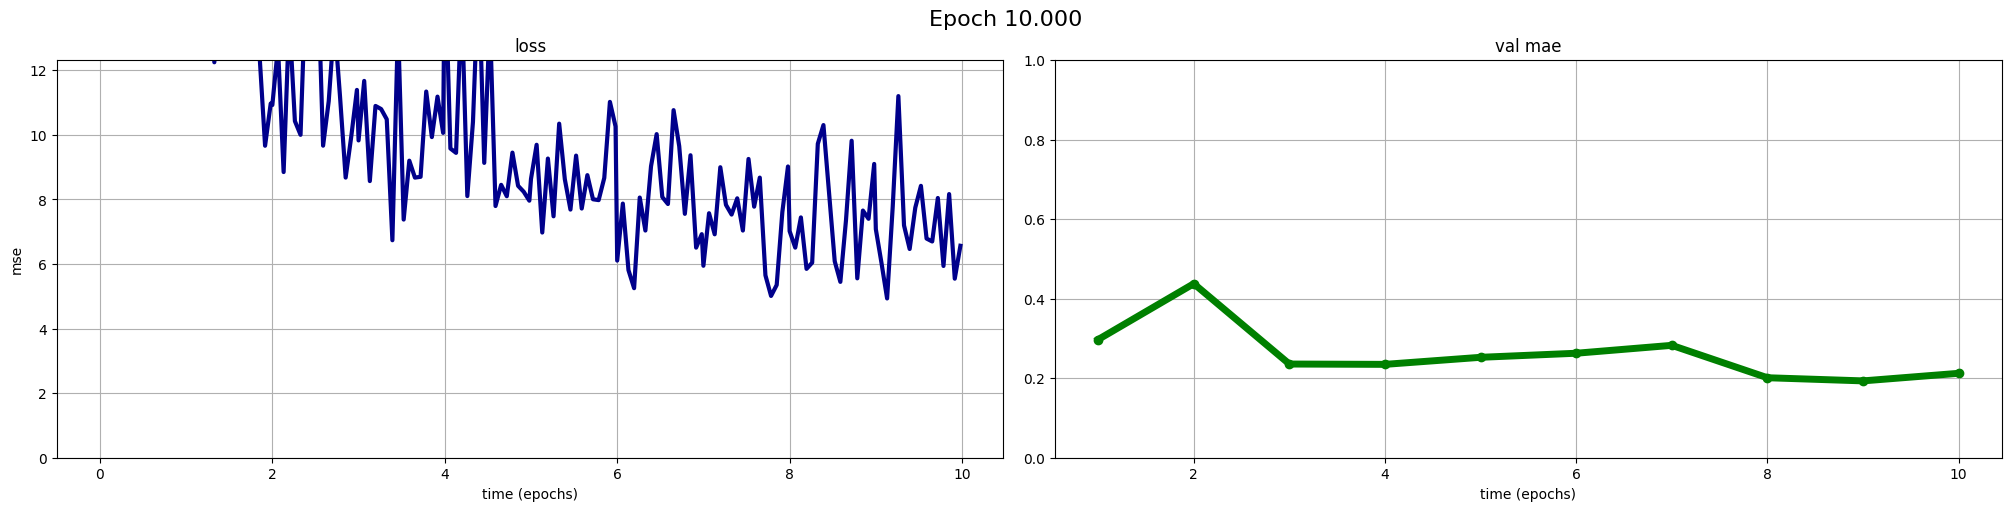

100%|██████████| 10/10 [08:12<00:00, 49.28s/it]


In [70]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [71]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.142305,0.273896,0.093494,0.093923,0.104979,0.113920,0.123887,0.071397,0.067282,0.078740
mae,0.297209,0.437576,0.235552,0.234734,0.252480,0.262706,0.282565,0.201104,0.193194,0.212241




Best MAE = 0.1932


#### Эксперимент 10: дообучаем эмбеддинги

In [74]:
model = SalaryPredictor(batch_norm=True, fine_tune=True).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

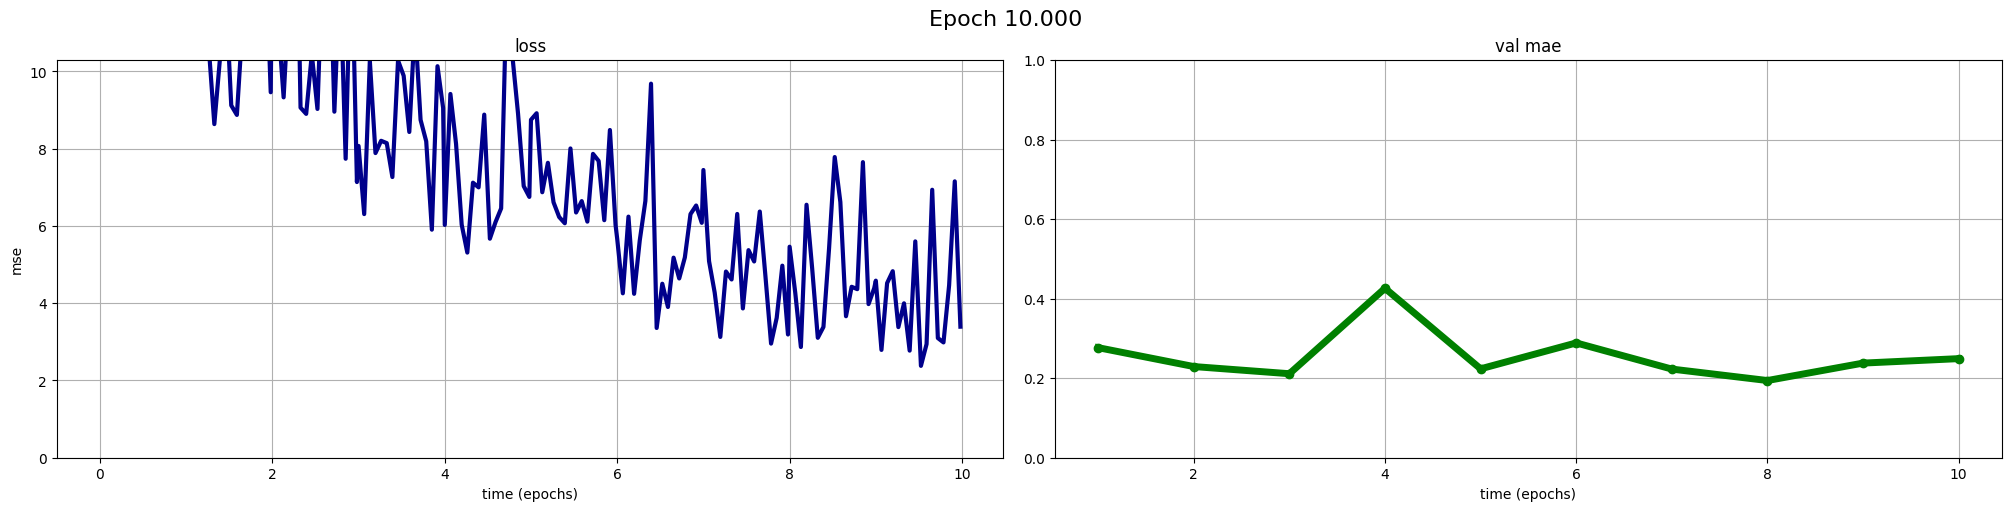

100%|██████████| 10/10 [09:45<00:00, 58.50s/it]


In [75]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [76]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.124118,0.089881,0.077167,0.231652,0.083471,0.124053,0.081015,0.065704,0.089132,0.096584
mae,0.276729,0.229245,0.211208,0.426011,0.223517,0.288657,0.222895,0.194088,0.237920,0.249127




Best MAE = 0.1941


#### Эксперимент 11: попробуем не шарить веса между title, description

In [77]:
class CategorialEncoder(nn.Module):
    def __init__(self, in_dim=len(categorical_vectorizer.vocabulary_), hid_size=64, batch_norm=False, dropout=0.0):
        super().__init__()
        self.batch_norm = batch_norm
        self.fc1 = nn.Linear(in_dim, 1024)
        self.fc2 = nn.Linear(1024, hid_size)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(1024)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        fc1 = self.dropout(F.relu(self.bn(self.fc1(x)))) if self.batch_norm else self.dropout(F.relu(self.fc1(x)))
        return self.fc2(fc1)


class TextEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), hid_size=64, batch_norm=False, dropout=0.0, pool='max', fine_tune=False):
        super().__init__()
        self.batch_norm = batch_norm
        self.emb = nn.Embedding.from_pretrained(embedding_matrix, freeze=not fine_tune)
        self.conv = nn.Conv1d(50, hid_size, kernel_size=3)
        if self.batch_norm:
            self.bn = nn.BatchNorm1d(hid_size)
        self.dropout = nn.Dropout(p=dropout)

        if pool == "max":
            self.pool  = self.max_pool
        elif pool == "avg":
            self.pool = self.avg_pool
        elif pool == "softmax":
            self.pool = self.softmax_pool

    def max_pool(self, x):
        return x.max(dim=-1).values

    def avg_pool(self, x):
        return x.mean(dim=-1)

    def softmax_pool(self, x):
        return (x * torch.nn.Softmax(dim=-1)(x)).sum(-1)

    def forward(self, x, pool='max'):
        emb = self.dropout(self.emb(x).transpose(2, 1))
        conv = F.relu(self.bn(self.conv(emb))) if self.batch_norm else F.relu(self.conv(emb))
        return self.pool(conv)

class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens),
                 n_cat_features=len(categorical_vectorizer.vocabulary_),
                 hid_size=64, dropout=0., batch_norm=False, pool='max', fine_tune=False):
        super().__init__()
        self.title_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool, fine_tune=fine_tune)
        self.descr_encoder = TextEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm, pool=pool, fine_tune=fine_tune)
        self.categ_encoder = CategorialEncoder(hid_size=hid_size, dropout=dropout, batch_norm=batch_norm)
        self.out = nn.Sequential(nn.Linear(hid_size * 3, hid_size),
                                  nn.BatchNorm1d(hid_size),
                                  nn.ReLU(),
                                  nn.Dropout(p=dropout),
                                  nn.Linear(hid_size, 1)
                                  )

    def forward(self, batch):
        x1 = self.title_encoder(batch['Title'])
        x2 = self.descr_encoder(batch['FullDescription'])
        x3 = self.categ_encoder(batch['Categorical'])
        x = torch.cat((x1, x2, x3), axis=-1)
        return torch.squeeze(self.out(x))

In [78]:
model = SalaryPredictor(batch_norm=True, fine_tune=True).to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters())

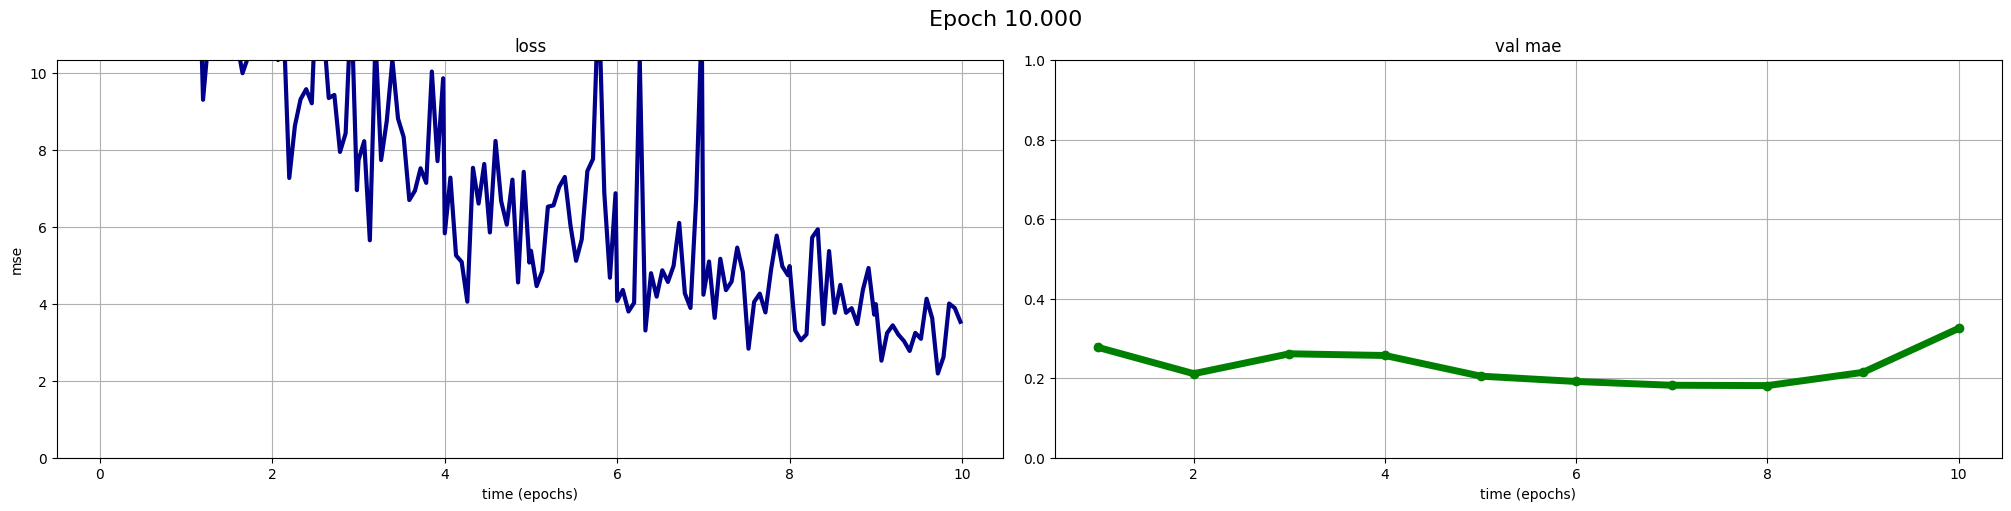

100%|██████████| 10/10 [09:21<00:00, 56.16s/it]


In [79]:
train_ts, train_mse = [], []
val_ts, val_mse, val_mae = [], [], []
model_weights, best_mae = run_experiment(model, criterion, optimizer)

In [80]:
df = pd.DataFrame(np.array([val_mse, val_mae]), columns=range(1, EPOCHS + 1), index=['mse', 'mae'])
display(df)
print('\n')
print(f'Best MAE = {best_mae:.4f}')

,1,2,3,4,5,6,7,8,9,10
mse,0.129152,0.077966,0.110443,0.10527,0.072891,0.064572,0.059378,0.059694,0.077985,0.147518
mae,0.277274,0.211307,0.261333,0.25706,0.205137,0.191670,0.182215,0.181355,0.214687,0.325132




Best MAE = 0.1814


### A short report

1. Попробовала обучать эмбеддинги с нуля и использовать эмбеддинги glove twitter 50, разницы особой нет, mae не опускается ниже 0.1814.

2. Улучшения, которые помогли: batch_norm, dropout исходных данных, параллельные свертки

## Recommended options

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm*`/`L.BatchNormalization`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to perform pooling:
* Max over time (independently for each feature)
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a dense layer.

The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$ (aka multi-headed attention).

The catch is that keras layers do not inlude those toys. You will have to [write your own keras layer](https://keras.io/layers/writing-your-own-keras-layers/). Or use pure tensorflow, it might even be easier :)

#### C) Fun with words

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained embeddings from `gensim.downloader.load`. See last lecture.
* Start with pre-trained embeddings, then fine-tune them with gradient descent. You may or may not download pre-trained embeddings from [here](http://nlp.stanford.edu/data/glove.6B.zip) and follow this [manual](https://keras.io/examples/nlp/pretrained_word_embeddings/) to initialize your Keras embedding layer with downloaded weights.
* Use the same embedding matrix in title and desc vectorizer


#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [early stopping callback(keras)](https://keras.io/callbacks/#earlystopping) or in [pytorch(lightning)](https://pytorch-lightning.readthedocs.io/en/latest/common/early_stopping.html).
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.save(file_name)`
  * Plotting learning curves is usually a good idea
  
Good luck! And may the force be with you!